# Shallow circulation analysis

How patterns of shallow convection are organizing is still an open question. By seeing parallels to the organization to deep convection, where a shallow circulation is increasing the difference between dry and moist regions ( working up-gradient), similar circulations might help to cluster the shallow pattern that recently have been named *Sugar, Gravel, Flowers, Fish*.

In order to investigate this circulation, and to quantify how much of such a potential circulation is radiatively driven circulation, a parallel analysis to the one in [Schulz et al. (2018)](https://doi.org/10.1175/JAS-D-17-0375.1) could be conducted with the data collected during EUREC$^4$A.

To be specific:
   - sorting profiles of moisture and radiative cooling from sources like radiosoundings, dropsondes, lidars (HALO, METEOR, BCO) by precipitable water
   - bin data by precipitable water
   - smoothing data
   - calculation of heating anomalies
   - calculating of radiatively driven circulations
   
This analysis could be split for the different patterns of meso-scale organizations to study the potential differences, that are potentially caused by different ranges of the moisture space ( *Sugar* small range of PW values; *Fish* high values of PW) or the different cloud field to name a few.

In combination to the radiatively driven circulations, the actually measured vertical velocities from e.g. the HALO circles could estimate the importans of the former.

Here is a quick and dirty starting point for the steps above:

In [1]:
fn_radiation_pw_sorted = './data/ds_radiation_sel_pw.nc'
overwrite = False

In [2]:
# Loading necessary modules
import tqdm
import os
import numpy as np

import xarray as xr

import scipy.ndimage
import scipy.signal

import metpy.calc as mpcalc

from metpy.units import units
import matplotlib.pyplot as plt

import circulation as circ
from deriv1d import deriv

## Computation of all necessary properties
- PW
- sorting by PW
- vertical velocity based on WTG
-...

In [3]:
if not os.path.exists(fn_radiation_pw_sorted) and overwrite is False:
    # Load radiation dataset
    try:
        ds_radiation = xr.open_dataset("https://observations.ipsl.fr/thredds/dodsC/EUREC4A/PRODUCTS/RADIATIVE-PROFILES/rad_profiles.nc", engine="pydap")
    except:
        ds_radiation = xr.open_dataset("./data/rad_profiles.nc")

    # Load radiation dataset into memory
    ds_radiation.load()

    # Remove duplicate timesteps (this drops about 6 soundings, 
    # where two platforms have launch a sonde at the same time)
    # For the fancy indixing, duplicates are causing errors, so
    # we remove those soundings from the dataset for simplicity
    _, uniq_ind = np.unique(ds_radiation.launch_time, return_index=True)
    ds_radiation_sel = ds_radiation.isel(launch_time = uniq_ind)

    # Calculation of precipitable water
    pw = np.empty(len(ds_radiation_sel.launch_time))
    pw.fill(np.nan)
    for s, snd in enumerate(tqdm.tqdm(ds_radiation_sel.launch_time)):
        # Only include soundings that went through the major part of the troposphere
        # Somehow the bottom and top arguments are not working here
        if ds_radiation_sel.isel(launch_time=s).pressure.min() <= 30000 and ds_radiation_sel.isel(launch_time=s).pressure.max() > 90000:
                dp = mpcalc.dewpoint_from_relative_humidity( ds_radiation_sel.isel(launch_time=s).temperature * units.kelvin,
                                                            ds_radiation_sel.isel(launch_time=s).relative_humidity/100)
                try:
                    pw[s] = mpcalc.precipitable_water(ds_radiation_sel.isel(launch_time=s).pressure * units.Pa,
                                              dp,
    #                                           bottom=850 * units.hPa,
    #                                           top=300 * units.hPa # for some reason not working here
                                             ).magnitude # in mm
                except ValueError:
                    pass

    ds_radiation_sel['pw'] = xr.DataArray(pw, dims=["launch_time"])
    
    # Remove soundings and heights that do not have a PW value
    pw_ind = np.where(ds_radiation_sel.pw > 0)[0]

    ds_radiation_sel_pw = ds_radiation_sel.isel(launch_time = pw_ind)
    # Remove all heights that contain any nan value
    ds_radiation_sel_pw = ds_radiation_sel_pw.dropna("alt")
    
    theta = mpcalc.potential_temperature(ds_radiation_sel_pw.pressure * units.Pa,
                                     ds_radiation_sel_pw.temperature * units.kelvin)
    ds_radiation_sel_pw["theta"] = theta
    dtheta_dp = np.empty((len(ds_radiation_sel_pw.launch_time), len(ds_radiation_sel_pw.alt)))
    dtheta_dp.fill(np.nan)
    for s, snd in enumerate(tqdm.tqdm(ds_radiation_sel_pw.launch_time)):
        dtheta_dp[s,:] = deriv(ds_radiation_sel_pw.isel(launch_time=s).pressure[::-1],
                               ds_radiation_sel_pw.isel(launch_time=s).theta[::-1])
    ds_radiation_sel_pw["dtheta_dp"] = xr.DataArray(dtheta_dp, dims = ["launch_time", "alt"])
    heating_anomaly = (ds_radiation_sel_pw.q_rad - np.nanmean(ds_radiation_sel_pw.q_rad,axis=0)) # axis 0 is altitude
    ds_radiation_sel_pw["heating_anomaly"] = xr.DataArray(heating_anomaly, dims = ["launch_time", "alt"])

    def smooth_field(data, window=(10,10)):
        """Apply gaussian filter to data
        """
        d_smoothed = scipy.ndimage.filters.gaussian_filter(data, window)
        return d_smoothed

    data_sorted = ds_radiation_sel_pw.sortby('pw').copy()
    for var in ['heating_anomaly', 'temperature', 'theta', 'dtheta_dp']:
         data_sorted[var+'_smooth'] =  (['alt', 'launch_time'], smooth_field(data_sorted[var].T))

    omega_clear_smooth = circ.wtg(data_sorted.temperature_smooth*units.kelvin,data_sorted.theta_smooth*units.kelvin,
                      data_sorted.heating_anomaly_smooth *units.kelvin/units.day,
                      data_sorted.dtheta_dp_smooth*units.kelvin/units.pascal)
    omega_clear = circ.wtg(ds_radiation_sel_pw.temperature*units.kelvin,ds_radiation_sel_pw.theta*units.kelvin,
                      ds_radiation_sel_pw.heating_anomaly *units.kelvin/units.day,
                      ds_radiation_sel_pw.dtheta_dp*units.kelvin/units.pascal)
    data_sorted["omega_clear_smooth"] = xr.DataArray(omega_clear_smooth.metpy.magnitude, dims = ["alt", "launch_time"])
    data_sorted["omega_clear"] = xr.DataArray(omega_clear.metpy.magnitude, dims = ["launch_time", "alt"])
    
    # Write to netcdf
    ds_dequantified = data_sorted.metpy.dequantify()
    for var in ds_dequantified.data_vars:
        ds_dequantified[var].encoding['zlib'] = True
    ds_dequantified.to_netcdf(fn_radiation_pw_sorted)

In [4]:
ds_dequantified = xr.open_dataset(fn_radiation_pw_sorted)

## Visualize data

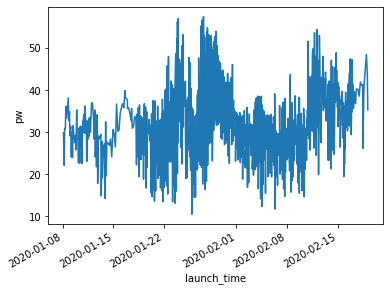

In [13]:
# Visualize precipitable water
ds_dequantified.pw.sortby('launch_time').plot()

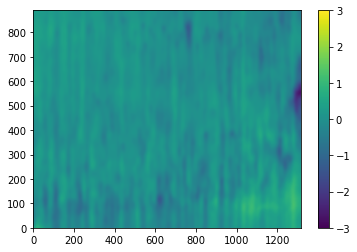

In [15]:
plt.pcolormesh(ds_dequantified.heating_anomaly_smooth, vmin=-3, vmax=3)
plt.colorbar();

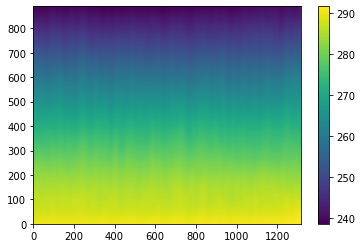

In [16]:
plt.pcolormesh(ds_dequantified.temperature_smooth)
plt.colorbar();

## Group data by PW
Single profiles contain too much noise, such that binning them helps to reduce that noise.

In [18]:
pw_bins = np.linspace(5,60,40)

In [19]:
# Group all data by precipitable water
ds_radiation_grp = ds_dequantified.groupby_bins("pw", pw_bins).mean()
ds_radiation_grp['profiles_per_bin'] = ds_dequantified.groupby_bins("pw", pw_bins).count().pw

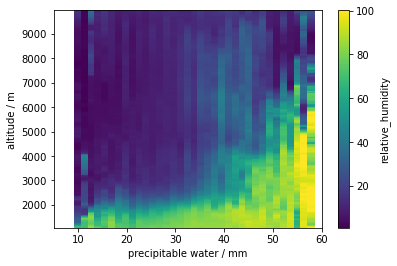

In [20]:
# Visualize the binned/grouped data
ds_radiation_grp.relative_humidity.T.plot()
plt.xlabel('precipitable water / mm')
plt.ylabel("altitude / m");

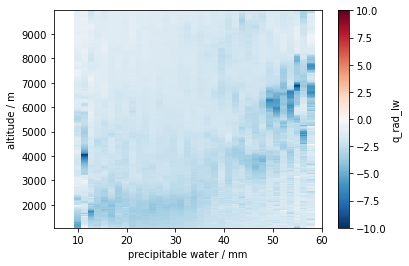

In [21]:
ds_radiation_grp.q_rad_lw.T.plot(vmin=-10,vmax=+10, cmap="RdBu_r")
plt.xlabel('precipitable water / mm')
plt.ylabel("altitude / m");

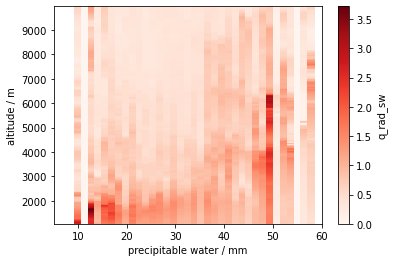

In [22]:
ds_radiation_grp.q_rad_sw.T.plot(cmap="Reds")
plt.xlabel('precipitable water / mm')
plt.ylabel("altitude / m");

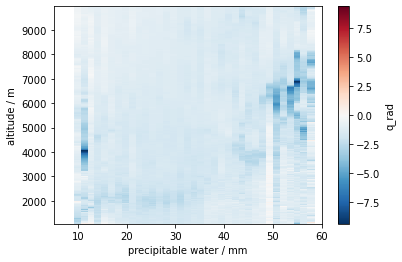

In [23]:
ds_radiation_grp.q_rad.T.plot(cmap="RdBu_r")
plt.xlabel('precipitable water / mm')
plt.ylabel("altitude / m");

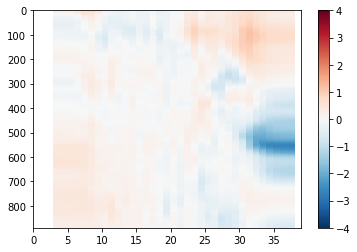

In [26]:
plt.pcolormesh(ds_radiation_grp.heating_anomaly_smooth.T, cmap="RdBu_r", vmin=-4, vmax=4)
plt.gca().invert_yaxis()
plt.colorbar()

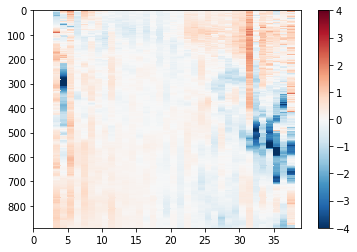

In [27]:
plt.pcolormesh(ds_radiation_grp.heating_anomaly.T, cmap="RdBu_r", vmin=-4, vmax=4)
plt.gca().invert_yaxis()
plt.colorbar()

In [28]:
# Drop nan bins
ds_radiation_mean = ds_radiation_grp.dropna("pw_bins", how="all")
# ds_radiation_mean_smooth = ds_radiation_grp_smooth.dropna("pw_bins", how="all")

In [29]:
heating_anomaly = (ds_radiation_mean.q_rad - np.nanmean(ds_radiation_mean.q_rad,axis=0)) # axis 0 is altitude
ds_radiation_mean["heating_anomaly_2"] = xr.DataArray(heating_anomaly, dims = ["pw_bins", "alt"])

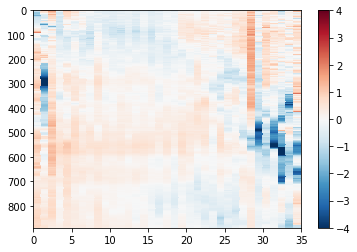

In [30]:
plt.pcolormesh(ds_radiation_mean.heating_anomaly_2.T, cmap="RdBu_r", vmin=-4, vmax=4)
plt.gca().invert_yaxis()
plt.colorbar()

In [31]:
omega_clear_2 = circ.wtg(ds_radiation_mean.temperature*units.kelvin,ds_radiation_mean.theta*units.kelvin,
                  ds_radiation_mean.heating_anomaly_2 *units.kelvin/units.day,
                  ds_radiation_mean.dtheta_dp*units.kelvin/units.pascal)
ds_radiation_mean["omega_clear_2"] = xr.DataArray(omega_clear_2.metpy.magnitude, dims = ["pw_bins", "alt"])

In [32]:
# # smooth specific fields
# omega_clear_smooth = scipy.ndimage.filters.gaussian_filter(ds_radiation_mean.omega_clear_2.T,(20,2))
# Q_anomaly_smooth = scipy.ndimage.filters.gaussian_filter(ds_radiation_mean.heating_anomaly_2.T,(20,2))

In [35]:
psi_smooth = circ.streamfunction_p(ds_radiation_mean.omega_clear_smooth.T.metpy.magnitude,ds_radiation_mean.pressure,
                       firstProfile=np.mean(ds_radiation_mean.omega_clear_smooth.T,0).metpy.magnitude,
                       alpha=1./len(ds_radiation_mean.heating_anomaly.T.metpy.magnitude))

[-0.00405214 -0.00405226 -0.00405365 -0.00427193 -0.0054473  -0.00578588
 -0.00297211 -0.00115361 -0.00262835 -0.00123162 -0.00101743 -0.00105881
 -0.00032736 -0.0001656  -0.00115502  0.00177442  0.00315564  0.00021299
  0.00204696 -0.00177797 -0.0027609   0.00036574  0.00024818  0.00186987
  0.00355882  0.00202473  0.00192195 -0.00086814 -0.00160847  0.00207095
  0.00512503  0.00743515  0.00839163  0.00875087  0.00888882]


In [36]:
# psi_smooth = circ.streamfunction_p(ds_radiation_grp_smooth.omega_clear_smooth.T.metpy.magnitude,ds_radiation_mean.pressure,
#                        firstProfile=np.mean(ds_radiation_grp_smooth.omega_clear_smooth.T,0).metpy.magnitude,
#                        alpha=1./len(ds_radiation_mean.heating_anomaly.T.metpy.magnitude))

In [39]:
psi = circ.streamfunction_p(omega_clear_2,ds_radiation_mean.pressure,
                       firstProfile=np.mean(omega_clear_2,0),
                       alpha=1./len(ds_radiation_mean.heating_anomaly))

[ 3.47845512e-03  5.80870225e-03 -5.58643817e-03  4.39916261e-03
  7.13911490e-03  3.58565801e-03  1.92359837e-03  1.99411186e-03
  1.55525088e-03  7.20520440e-04  1.15771225e-03  6.67776068e-03
  3.38466387e-03  1.64773155e-03 -2.59940394e-03  2.83400890e-03
 -3.97812306e-02 -2.45601965e-03 -2.97880815e-03 -7.47381818e-04
  1.17859706e-04  8.07328333e-04  1.55391198e-03  1.06082618e-03
 -1.95633090e-04  7.27445410e-04  5.23916698e-04 -3.32287725e-04
 -1.03667241e-03 -8.11619412e-04 -1.13143000e-02  2.94860694e-03
  8.44787223e-04  3.42144904e-04  4.76653083e-05  8.48512169e-04
 -3.91435739e-03  8.96522200e-05 -2.53966191e-04  4.17739910e-04
  1.52582273e-03  2.50792507e-03  7.37303215e-03  2.25118221e-03
  1.14234092e-03  6.80451985e-04  4.80565716e-04  5.13965658e-04
  5.36906497e-04  8.56790589e-04  7.23097618e-04 -1.39466945e-03
 -2.66464741e-03  1.10842857e-02 -3.81719686e-03 -3.60763238e-04
 -1.81334426e-03 -7.99211349e-04 -6.93267764e-04 -1.36960582e-03
  2.40117644e-03  4.53075

DimensionalityError: Cannot convert from 'dimensionless' to 'pascal / day'

In [41]:
np.shape(omega_clear_2.metpy.magnitude*860.)

(35, 890)

<ipython-input-93-25fb5d839556>:6: UserWarning: The following kwargs were not used by contour: 'interpolation'
  p1  = ax.contourf(np.arange(len(ds_radiation_grp_smooth.omega_clear_smooth.T.metpy.magnitude.T)),ds_radiation_grp_smooth.pressure.mean(dim="pw_bins")/100,


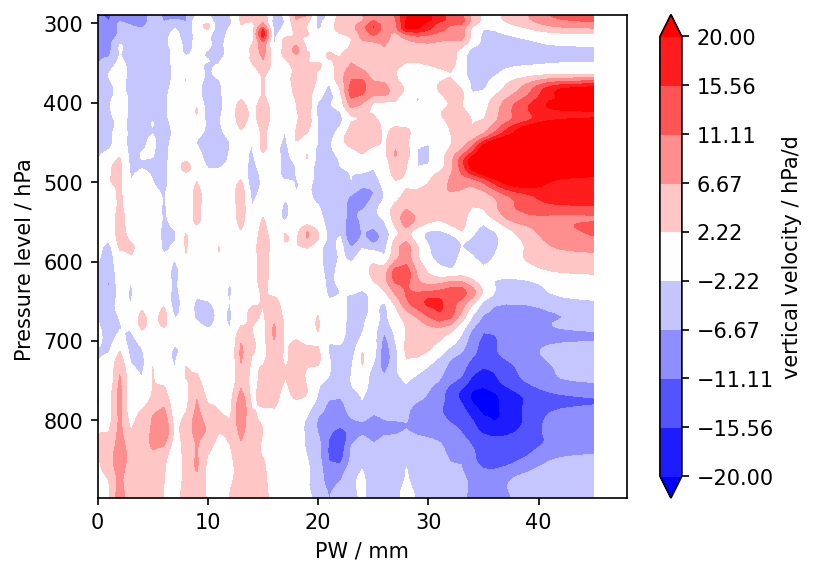

In [93]:
fig = plt.figure(figsize=(5.69,4.27), dpi=150)
ax  = plt.subplot(111)
bound = np.nanmax([np.abs(np.nanpercentile(ds_radiation_grp_smooth.omega_clear_smooth.T.metpy.magnitude*860.,1)),
                   np.abs(np.nanpercentile(ds_radiation_grp_smooth.omega_clear_smooth.T.metpy.magnitude*860.,99))])
bound = 20
p1  = ax.contourf(np.arange(len(ds_radiation_grp_smooth.omega_clear_smooth.T.metpy.magnitude.T)),ds_radiation_grp_smooth.pressure.mean(dim="pw_bins")/100,
                  ds_radiation_grp_smooth.omega_clear_smooth.metpy.magnitude.T*860.,cmap="bwr",levels=np.linspace(-bound,+bound,10),
                  interpolation="none",extend="both")
# plt.gca().invert_yaxis()
# ax.set_xlabel(r'Percentile of IWV')
# ax.set_xticklabels(['0','20','40','60','80','100'])

ax.set_ylabel("Pressure level / hPa ")
ax.set_xlabel("PW / mm")
ax.invert_yaxis()
c1 = plt.colorbar(p1)
c1.set_label("vertical velocity / hPa/d")

<ipython-input-88-6e713807e83d>:6: UserWarning: The following kwargs were not used by contour: 'interpolation'
  p1  = ax.contourf(np.arange(len(omega_clear_smooth.T.metpy.magnitude)),ds_radiation_mean_smooth.pressure.mean(dim="pw_bins")/100,


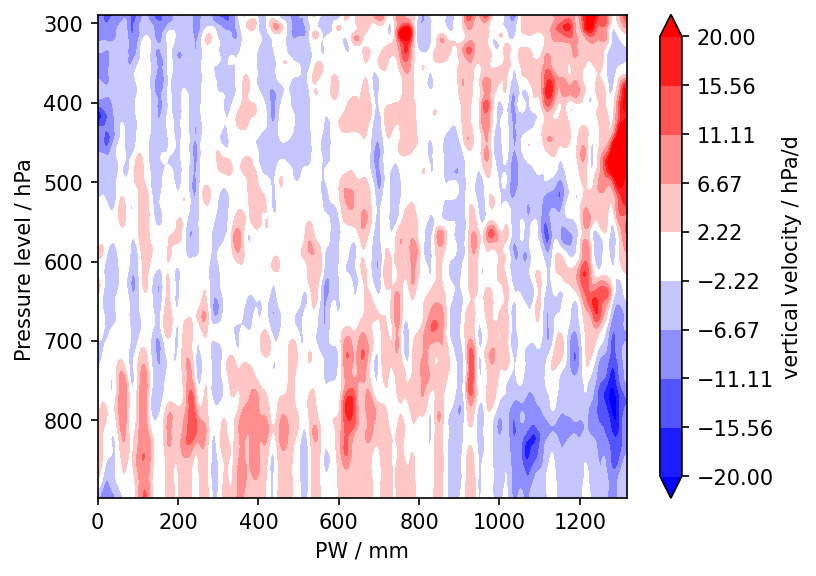

In [88]:
fig = plt.figure(figsize=(5.69,4.27), dpi=150)
ax  = plt.subplot(111)
bound = np.nanmax([np.abs(np.nanpercentile(omega_clear_smooth.T.metpy.magnitude*860.,1)),
                   np.abs(np.nanpercentile(omega_clear_smooth.T.metpy.magnitude*860.,99))])
bound = 20
p1  = ax.contourf(np.arange(len(omega_clear_smooth.T.metpy.magnitude)),ds_radiation_mean_smooth.pressure.mean(dim="pw_bins")/100,
                  omega_clear_smooth.metpy.magnitude*860.,cmap="bwr",levels=np.linspace(-bound,+bound,10),
                  interpolation="none",extend="both")
# plt.gca().invert_yaxis()
# ax.set_xlabel(r'Percentile of IWV')
# ax.set_xticklabels(['0','20','40','60','80','100'])

ax.set_ylabel("Pressure level / hPa ")
ax.set_xlabel("PW / mm")
ax.invert_yaxis()
c1 = plt.colorbar(p1)
c1.set_label("vertical velocity / hPa/d")

<ipython-input-178-2ef55bc6358a>:6: UserWarning: The following kwargs were not used by contour: 'interpolation'
  p1  = ax.contourf(np.arange(len(omega_clear_smooth.T)),ds_radiation_mean.pressure.mean(dim="pw_bins")/100,


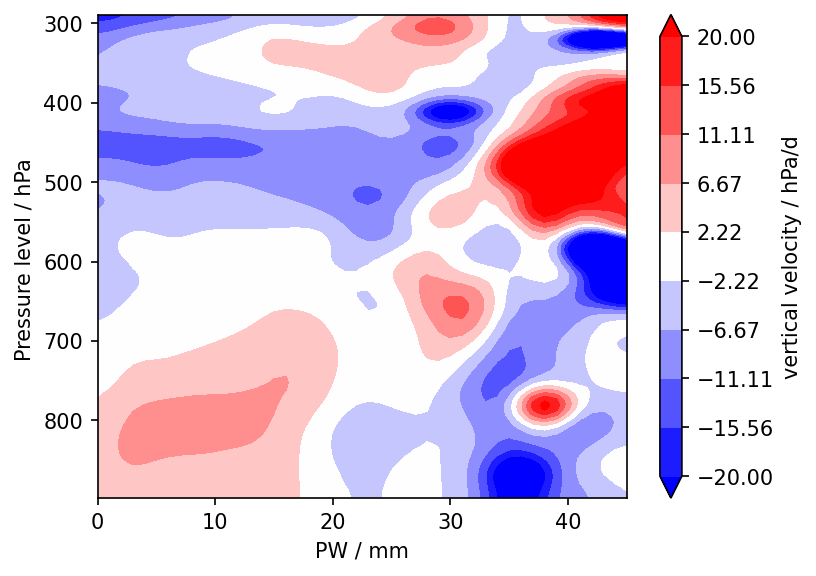

In [178]:
fig = plt.figure(figsize=(5.69,4.27), dpi=150)
ax  = plt.subplot(111)
bound = np.nanmax([np.abs(np.nanpercentile(omega_clear_smooth*860.,1)),
                   np.abs(np.nanpercentile(omega_clear_smooth*860.,99))])
bound = 20
p1  = ax.contourf(np.arange(len(omega_clear_smooth.T)),ds_radiation_mean.pressure.mean(dim="pw_bins")/100,
                  omega_clear_smooth*860.,cmap="bwr",levels=np.linspace(-bound,+bound,10),
                  interpolation="none",extend="both")
# plt.gca().invert_yaxis()
# ax.set_xlabel(r'Percentile of IWV')
# ax.set_xticklabels(['0','20','40','60','80','100'])

ax.set_ylabel("Pressure level / hPa ")
ax.set_xlabel("PW / mm")
ax.invert_yaxis()
c1 = plt.colorbar(p1)
c1.set_label("vertical velocity / hPa/d")

<ipython-input-184-352b55d0fbbf>:13: UserWarning: The following kwargs were not used by contour: 'interpolation'
  p1  = ax.contour(np.arange(len(omega_clear_smooth.T)),


The contourlines are drawn from -0.015 to 0.015 with 20 intervals


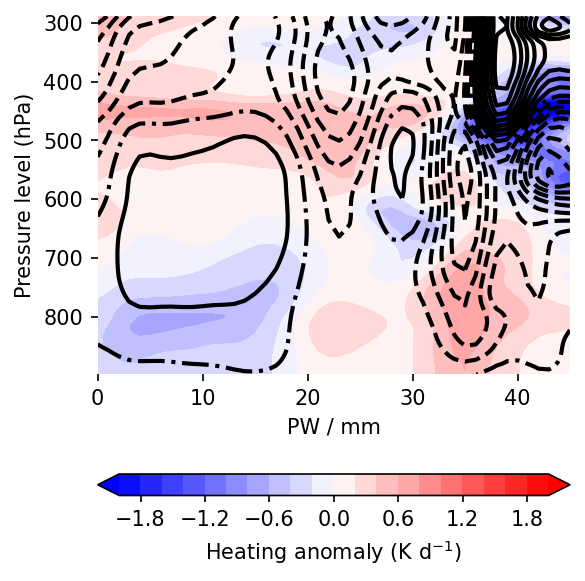

In [184]:
fig = plt.figure(figsize=plt.figaspect(1), dpi=150)
ax  = plt.subplot(111)
bound = np.round(np.nanmax([np.abs(np.nanpercentile(Q_anomaly_smooth,1)),
                            np.abs(np.nanpercentile(Q_anomaly_smooth,99))]))
cq1 = ax.contourf(np.arange(len(Q_anomaly_smooth.T)),
                  ds_radiation_mean.pressure.mean(dim="pw_bins")/100,
                  Q_anomaly_smooth,cmap="bwr",
                  levels=np.linspace(-bound,+bound,21),
                  extend="both")
bound = np.round(np.nanmax([np.abs(np.nanpercentile(psi.T,1)),
                            np.abs(np.nanpercentile(psi.T,99))]),3)

p1  = ax.contour(np.arange(len(omega_clear_smooth.T)),
                 ds_radiation_mean.pressure.mean(dim="pw_bins")/100,psi[1:,:],colors='k',
                 levels=np.linspace(-bound,+bound,17),
                 interpolation="none",extend="both", linewidths=2) #21 lines
p1.collections[8].set_linestyle('-.')

print("The contourlines are drawn from {} to {} with 20 intervals".format(-bound,+bound))
ax.set_xlabel(r'PW / mm')
# ax.set_xticklabels(['0','20','40','60','80','100'])
cb  = fig.colorbar(cq1, ax=ax,fraction=0.08,orientation="horizontal",pad=0.2)
cb.set_label(r"Heating anomaly (K d$^{-1}$)")

ax.set_ylabel("Pressure level (hPa)")
ax.invert_yaxis()
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.tight_layout()
plt.show()

## Ignore days with Ac clouds
The Ac layer that was present at least for 14.2.2020 - 16.2.2020 has a clear influence on the radiative heating cross section in moisture space. Because this layer has so far not been associated with any particular pattern, we disregard those days in the following to get a more ideal/informative picture.